In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm


In [17]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_12_extra_clean.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_12_extra_clean.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=42
)
# X_train, X_test, y_train, y_test = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42
# )


In [18]:
# with open("inputs_small_train_36.pkl", "wb") as f:
#     pickle.dump(X_train, f)

# with open("inputs_small_test_36.pkl", "wb") as f:
#     pickle.dump(X_test, f)
# # Save targets
# with open("targets_small_train_36.pkl", "wb") as f:
#     pickle.dump(y_train, f)
# with open("targets_small_test_36.pkl", "wb") as f:
#     pickle.dump(y_test, f)

In [19]:
# with open("inputs_small_train_36.pkl", "rb") as f:
#     X_train = pickle.load(f)

# with open("inputs_small_test_36.pkl", "rb") as f:
#     X_test = pickle.load(f)
# # Save targets
# with open("targets_small_train_36.pkl", "rb") as f:
#     Y_train = pickle.load(f)
# with open("targets_small_test_36.pkl", "rb") as f:
#     Y_test = pickle.load(f)

In [20]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3]  # NDVI, NDBI, Albedo, agg_month (example)

# Flatten for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_test_flat = X_test.reshape(-1, X_test.shape[2])

# Initialize a new array to hold the scaled data
X_train_scaled = X_train_flat.copy()
X_test_scaled = X_test_flat.copy()

scaler = StandardScaler()

# Fit and transform only the continuous columns
X_train_scaled[:, norm_idx] = scaler.fit_transform(X_train_flat[:, norm_idx])
X_test_scaled[:, norm_idx] = scaler.transform(X_test_flat[:, norm_idx])

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_test = X_test_scaled.reshape(X_test.shape)

y_train_flat = Y_train.reshape(-1, 1)
y_test_flat = Y_test.reshape(-1, 1)

standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_test_scaled = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_test = y_test_scaled.reshape(Y_test.shape)



In [21]:
X_train.shape

(312540, 12, 17)

In [22]:
X_train

array([[[ 6.4197034e-01,  3.4701911e-01, -5.1777607e-01, ...,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [-9.5707870e-01, -3.4079037e+00,  2.3335025e+00, ...,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [-4.0094215e-01,  9.8045427e-01, -9.1256255e-01, ...,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        ...,
        [-4.9467707e-01,  8.7643743e-01, -1.0831739e+00, ...,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [-6.9307965e-01,  3.6263995e-02, -6.0407084e-01, ...,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [-2.4734606e-01, -4.5679572e-01,  8.1082821e-02, ...,
          0.0000000e+00,  1.0000000e+00,  0.0000000e+00]],

       [[ 2.1810259e-01,  2.6804172e-03, -1.1865986e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 6.2010515e-01,  2.4851322e-01, -3.5520452e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.3907953e-01, 

In [23]:
Y_train.shape

(312540,)

In [24]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [25]:
device = torch.device("cuda")
device

device(type='cuda')

In [26]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=1536, num_layers=3, dropout=0.3):
        super(LSTMPredictor, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)  # Output = scalar

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        last_time_step = lstm_out[:, -1, :]  # take the last time step's output
        out = self.fc(last_time_step)  # (batch_size, 1)
        return out.squeeze(1)  # final shape: (batch_size,)
    


  1%|          | 1/100 [00:16<27:58, 16.95s/it]

Epoch 1/100 - Train Loss: 0.16065819561481476


  2%|▏         | 2/100 [00:33<27:45, 16.99s/it]

Epoch 2/100 - Train Loss: 0.10739171504974365


  3%|▎         | 3/100 [00:50<27:26, 16.97s/it]

Epoch 3/100 - Train Loss: 0.1284804791212082


  4%|▍         | 4/100 [01:08<27:14, 17.02s/it]

Epoch 4/100 - Train Loss: 0.08969389647245407


  5%|▌         | 5/100 [01:25<27:00, 17.05s/it]

Epoch 5/100 - Train Loss: 0.09813433140516281


  6%|▌         | 6/100 [01:42<26:40, 17.03s/it]

Epoch 6/100 - Train Loss: 0.1479591280221939


  7%|▋         | 7/100 [01:59<26:26, 17.06s/it]

Epoch 7/100 - Train Loss: 0.0841844454407692


  8%|▊         | 8/100 [02:16<26:10, 17.07s/it]

Epoch 8/100 - Train Loss: 0.0706530436873436


  9%|▉         | 9/100 [02:33<25:51, 17.05s/it]

Epoch 9/100 - Train Loss: 0.07967129349708557


 10%|█         | 10/100 [02:50<25:36, 17.07s/it]

Epoch 10/100 - Train Loss: 0.06256303936243057


 11%|█         | 11/100 [03:07<25:21, 17.09s/it]

Epoch 11/100 - Train Loss: 0.1213482916355133


 12%|█▏        | 12/100 [03:24<25:05, 17.11s/it]

Epoch 12/100 - Train Loss: 0.11561809480190277


 13%|█▎        | 13/100 [03:41<24:45, 17.08s/it]

Epoch 13/100 - Train Loss: 0.06129731982946396


 14%|█▍        | 14/100 [03:58<24:29, 17.09s/it]

Epoch 14/100 - Train Loss: 0.20387418568134308


 15%|█▌        | 15/100 [04:16<24:13, 17.10s/it]

Epoch 15/100 - Train Loss: 0.056591205298900604


 16%|█▌        | 16/100 [04:32<23:53, 17.07s/it]

Epoch 16/100 - Train Loss: 0.07513295859098434


 17%|█▋        | 17/100 [04:50<23:37, 17.08s/it]

Epoch 17/100 - Train Loss: 0.09015296399593353


 18%|█▊        | 18/100 [05:07<23:21, 17.09s/it]

Epoch 18/100 - Train Loss: 0.0940723791718483


 19%|█▉        | 19/100 [05:24<23:01, 17.05s/it]

Epoch 19/100 - Train Loss: 0.08925044536590576


 20%|██        | 20/100 [05:41<22:45, 17.07s/it]

Epoch 20/100 - Train Loss: 0.03855406865477562


 21%|██        | 21/100 [05:58<22:29, 17.09s/it]

Epoch 21/100 - Train Loss: 0.06678549945354462


 22%|██▏       | 22/100 [06:15<22:10, 17.06s/it]

Epoch 22/100 - Train Loss: 0.1158333420753479


 23%|██▎       | 23/100 [06:32<21:54, 17.07s/it]

Epoch 23/100 - Train Loss: 0.08956662565469742


 24%|██▍       | 24/100 [06:49<21:38, 17.09s/it]

Epoch 24/100 - Train Loss: 0.07828228175640106


 25%|██▌       | 25/100 [07:06<21:18, 17.05s/it]

Epoch 25/100 - Train Loss: 0.07319130748510361


 26%|██▌       | 26/100 [07:23<21:03, 17.07s/it]

Epoch 26/100 - Train Loss: 0.09263508766889572


 27%|██▋       | 27/100 [07:40<20:47, 17.08s/it]

Epoch 27/100 - Train Loss: 0.08133948594331741


 28%|██▊       | 28/100 [07:57<20:31, 17.10s/it]

Epoch 28/100 - Train Loss: 0.09521886706352234


 29%|██▉       | 29/100 [08:14<20:11, 17.06s/it]

Epoch 29/100 - Train Loss: 0.057111505419015884


 30%|███       | 30/100 [08:32<19:55, 17.08s/it]

Epoch 30/100 - Train Loss: 0.056666284799575806


 31%|███       | 31/100 [08:49<19:38, 17.08s/it]

Epoch 31/100 - Train Loss: 0.08948808163404465


 32%|███▏      | 32/100 [09:06<19:19, 17.05s/it]

Epoch 32/100 - Train Loss: 0.06290458142757416


 33%|███▎      | 33/100 [09:23<19:03, 17.06s/it]

Epoch 33/100 - Train Loss: 0.10379020869731903


 34%|███▍      | 34/100 [09:40<18:46, 17.07s/it]

Epoch 34/100 - Train Loss: 0.048485808074474335


 35%|███▌      | 35/100 [09:57<18:27, 17.04s/it]

Epoch 35/100 - Train Loss: 0.06454191356897354


 36%|███▌      | 36/100 [10:14<18:11, 17.06s/it]

Epoch 36/100 - Train Loss: 0.0952649787068367


 37%|███▋      | 37/100 [10:31<17:55, 17.07s/it]

Epoch 37/100 - Train Loss: 0.04168882593512535


 38%|███▊      | 38/100 [10:48<17:36, 17.04s/it]

Epoch 38/100 - Train Loss: 0.0504290945827961


 39%|███▉      | 39/100 [11:05<17:20, 17.06s/it]

Epoch 39/100 - Train Loss: 0.06327497959136963


 40%|████      | 40/100 [11:22<17:04, 17.07s/it]

Epoch 40/100 - Train Loss: 0.06338507682085037


 41%|████      | 41/100 [11:39<16:44, 17.03s/it]

Epoch 41/100 - Train Loss: 0.08381855487823486


 42%|████▏     | 42/100 [11:56<16:28, 17.05s/it]

Epoch 42/100 - Train Loss: 0.05571173503994942


 43%|████▎     | 43/100 [12:13<16:12, 17.07s/it]

Epoch 43/100 - Train Loss: 0.07068820297718048


 44%|████▍     | 44/100 [12:30<15:56, 17.07s/it]

Epoch 44/100 - Train Loss: 0.047355130314826965


 45%|████▌     | 45/100 [12:47<15:37, 17.04s/it]

Epoch 45/100 - Train Loss: 0.05243604630231857


 46%|████▌     | 46/100 [13:04<15:21, 17.06s/it]

Epoch 46/100 - Train Loss: 0.054832782596349716


 47%|████▋     | 47/100 [13:22<15:04, 17.07s/it]

Epoch 47/100 - Train Loss: 0.0673774778842926


 48%|████▊     | 48/100 [13:39<14:46, 17.04s/it]

Epoch 48/100 - Train Loss: 0.05049271136522293


 49%|████▉     | 49/100 [13:56<14:30, 17.06s/it]

Epoch 49/100 - Train Loss: 0.05259358882904053


 50%|█████     | 50/100 [14:13<14:13, 17.07s/it]

Epoch 50/100 - Train Loss: 0.0449649915099144


 51%|█████     | 51/100 [14:30<13:55, 17.04s/it]

Epoch 51/100 - Train Loss: 0.06384224444627762


 52%|█████▏    | 52/100 [14:47<13:38, 17.06s/it]

Epoch 52/100 - Train Loss: 0.046772703528404236


 53%|█████▎    | 53/100 [15:04<13:22, 17.08s/it]

Epoch 53/100 - Train Loss: 0.05298721417784691


 54%|█████▍    | 54/100 [15:21<13:03, 17.04s/it]

Epoch 54/100 - Train Loss: 0.061995670199394226


 55%|█████▌    | 55/100 [15:38<12:47, 17.06s/it]

Epoch 55/100 - Train Loss: 0.09687425196170807


 56%|█████▌    | 56/100 [15:55<12:31, 17.07s/it]

Epoch 56/100 - Train Loss: 0.057460688054561615


 57%|█████▋    | 57/100 [16:12<12:12, 17.04s/it]

Epoch 57/100 - Train Loss: 0.04937691241502762


 58%|█████▊    | 58/100 [16:29<11:56, 17.06s/it]

Epoch 58/100 - Train Loss: 0.05307331308722496


 59%|█████▉    | 59/100 [16:46<11:39, 17.07s/it]

Epoch 59/100 - Train Loss: 0.06520739197731018


 60%|██████    | 60/100 [17:03<11:23, 17.08s/it]

Epoch 60/100 - Train Loss: 0.06249874085187912


 61%|██████    | 61/100 [17:20<11:04, 17.05s/it]

Epoch 61/100 - Train Loss: 0.04766907915472984


 62%|██████▏   | 62/100 [17:37<10:48, 17.06s/it]

Epoch 62/100 - Train Loss: 0.06212182343006134


 63%|██████▎   | 63/100 [17:54<10:31, 17.07s/it]

Epoch 63/100 - Train Loss: 0.06095992401242256


 64%|██████▍   | 64/100 [18:11<10:13, 17.03s/it]

Epoch 64/100 - Train Loss: 0.06123276427388191


 65%|██████▌   | 65/100 [18:29<09:56, 17.05s/it]

Epoch 65/100 - Train Loss: 0.05337145924568176


 66%|██████▌   | 66/100 [18:46<09:39, 17.06s/it]

Epoch 66/100 - Train Loss: 0.06995953619480133


 67%|██████▋   | 67/100 [19:03<09:21, 17.03s/it]

Epoch 67/100 - Train Loss: 0.07182177156209946


 68%|██████▊   | 68/100 [19:20<09:05, 17.04s/it]

Epoch 68/100 - Train Loss: 0.03999511897563934


 69%|██████▉   | 69/100 [19:37<08:48, 17.05s/it]

Epoch 69/100 - Train Loss: 0.04705198481678963


 70%|███████   | 70/100 [19:54<08:30, 17.02s/it]

Epoch 70/100 - Train Loss: 0.039864711463451385


 71%|███████   | 71/100 [20:11<08:14, 17.04s/it]

Epoch 71/100 - Train Loss: 0.046076174825429916


 72%|███████▏  | 72/100 [20:28<07:57, 17.05s/it]

Epoch 72/100 - Train Loss: 0.06127290055155754


 73%|███████▎  | 73/100 [20:45<07:39, 17.02s/it]

Epoch 73/100 - Train Loss: 0.06094064563512802


 74%|███████▍  | 74/100 [21:02<07:22, 17.03s/it]

Epoch 74/100 - Train Loss: 0.08357413858175278


 75%|███████▌  | 75/100 [21:19<07:05, 17.04s/it]

Epoch 75/100 - Train Loss: 0.05307002365589142


 76%|███████▌  | 76/100 [21:36<06:49, 17.05s/it]

Epoch 76/100 - Train Loss: 0.03817303106188774


 77%|███████▋  | 77/100 [21:53<06:31, 17.01s/it]

Epoch 77/100 - Train Loss: 0.06780518591403961


 78%|███████▊  | 78/100 [22:10<06:14, 17.02s/it]

Epoch 78/100 - Train Loss: 0.05041465535759926


 79%|███████▉  | 79/100 [22:27<05:57, 17.03s/it]

Epoch 79/100 - Train Loss: 0.035478632897138596


 80%|████████  | 80/100 [22:44<05:39, 16.99s/it]

Epoch 80/100 - Train Loss: 0.046846263110637665


 81%|████████  | 81/100 [23:01<05:23, 17.01s/it]

Epoch 81/100 - Train Loss: 0.03160104900598526


 82%|████████▏ | 82/100 [23:18<05:06, 17.02s/it]

Epoch 82/100 - Train Loss: 0.047824569046497345


 83%|████████▎ | 83/100 [23:35<04:48, 16.99s/it]

Epoch 83/100 - Train Loss: 0.04934552311897278


 84%|████████▍ | 84/100 [23:52<04:32, 17.02s/it]

Epoch 84/100 - Train Loss: 0.05529215559363365


 85%|████████▌ | 85/100 [24:09<04:15, 17.04s/it]

Epoch 85/100 - Train Loss: 0.048480547964572906


 86%|████████▌ | 86/100 [24:26<03:58, 17.01s/it]

Epoch 86/100 - Train Loss: 0.0849563330411911


 87%|████████▋ | 87/100 [24:43<03:41, 17.03s/it]

Epoch 87/100 - Train Loss: 0.04274881258606911


 88%|████████▊ | 88/100 [25:00<03:24, 17.04s/it]

Epoch 88/100 - Train Loss: 0.03774915635585785


 89%|████████▉ | 89/100 [25:17<03:07, 17.01s/it]

Epoch 89/100 - Train Loss: 0.04455271363258362


 90%|█████████ | 90/100 [25:34<02:50, 17.02s/it]

Epoch 90/100 - Train Loss: 0.03893975913524628


 91%|█████████ | 91/100 [25:51<02:33, 17.04s/it]

Epoch 91/100 - Train Loss: 0.054548487067222595


 92%|█████████▏| 92/100 [26:08<02:16, 17.05s/it]

Epoch 92/100 - Train Loss: 0.02783684991300106


 93%|█████████▎| 93/100 [26:25<01:59, 17.01s/it]

Epoch 93/100 - Train Loss: 0.03762294724583626


 94%|█████████▍| 94/100 [26:42<01:42, 17.03s/it]

Epoch 94/100 - Train Loss: 0.05031547322869301


 95%|█████████▌| 95/100 [26:59<01:25, 17.04s/it]

Epoch 95/100 - Train Loss: 0.05237983912229538


 96%|█████████▌| 96/100 [27:16<01:07, 17.00s/it]

Epoch 96/100 - Train Loss: 0.07140824943780899


 97%|█████████▋| 97/100 [27:35<00:52, 17.43s/it]

Epoch 97/100 - Train Loss: 0.06589900702238083


 98%|█████████▊| 98/100 [27:55<00:36, 18.25s/it]

Epoch 98/100 - Train Loss: 0.11166076362133026


 99%|█████████▉| 99/100 [28:15<00:18, 18.79s/it]

Epoch 99/100 - Train Loss: 0.04963582381606102


100%|██████████| 100/100 [28:35<00:00, 17.16s/it]

Epoch 100/100 - Train Loss: 0.05846032872796059


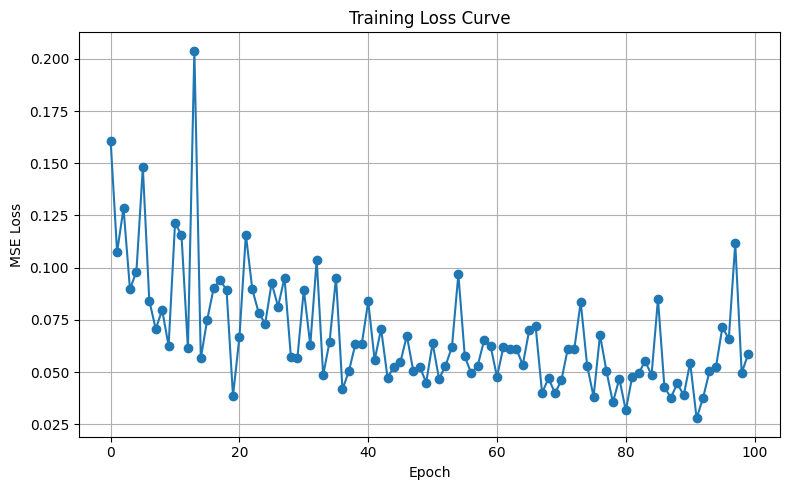

In [27]:
input_size = X_train.shape[2]  # num_features per timestep
model = LSTMPredictor(input_size=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
train_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())
plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")

Test MSE:  6.6641
Test RMSE: 2.5815
Test MAE:  1.4518
Test R²:   0.9150
Test MAPE:   0.0787
